# III. Convoluted Neural Networks (CNN) 
---

This section builds a CNN using both non-augmented and augmented data. I evaluate the performance of the models based on accuracy and loss, and also test the models on numerous test images.

In [79]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from numpy import savetxt
from IPython.display import Image

from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.preprocessing.image import load_img, img_to_array, smart_resize
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score

# For reproducibility
np.random.seed(42)
from numpy.random import seed
seed(42)

In [80]:
# Mount G-Drive folder.
from google.colab import drive
drive.mount('/content/drive/', force_remount = True)

Mounted at /content/drive/


In [81]:
# Recreate train_ds and val_ds for modelling.

train_df = image_dataset_from_directory(
    '/content/drive/MyDrive/Capstone/images', # Directory
    image_size = (256, 256), # make sure all images are the same size
    batch_size = 32, # This will load 32 images at a time, memory can't hold them all
    seed = 42, # random seed for reproducibility
    validation_split = 0.2, 
    subset = 'training',
    label_mode = 'binary'
)

val_ds = image_dataset_from_directory(
    '/content/drive/MyDrive/Capstone/images',
    image_size = (256, 256),
    batch_size = 32,
    seed = 42,
    validation_split = 0.2,
    subset = 'validation',
    label_mode = 'binary'
)

Found 1047 files belonging to 2 classes.
Using 838 files for training.
Found 1047 files belonging to 2 classes.
Using 209 files for validation.


---
## CNN Model without data augmentation

---

Below I create a CNN wiith 2 convoluted layers, with early stopping and dropout to help minimize overfitness/maximize performance.

In [82]:
es = EarlyStopping(patience = 5)

In [83]:
# Create base CNN model.
model = Sequential()

model.add(layers.Input(shape = (256,256,3)))\



# The 1. below guarentees a float for the normalization.
model.add(layers.Rescaling(1./255))


# Add first convolution.
model.add(Conv2D(64, # Number of filters
                 (3,3), # Kernal size, generally 3 by 3
                 activation = 'relu'))

# Pass into the max pooling layer.
model.add(MaxPooling2D(pool_size = (2,2), # Default pool size
                       ))
# Add second Convolution
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Flatten.
model.add(Flatten())

# Add Dropout layer.
model.add(Dropout(.5))

# Fully connected layers.
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

#Compile model.
model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'],
)

In [84]:
# Fit the model.
base = model.fit(train_df, validation_data= val_ds, epochs = 10, workers = 8, callbacks = [es])

Epoch 1/10
27/27 [==============================] - 3s 34ms/step - loss: 1.0296 - accuracy: 0.5871 - val_loss: 0.6489 - val_accuracy: 0.5311
Epoch 2/10
27/27 [==============================] - 1s 27ms/step - loss: 0.5323 - accuracy: 0.7208 - val_loss: 0.4583 - val_accuracy: 0.7751
Epoch 3/10
27/27 [==============================] - 1s 27ms/step - loss: 0.4903 - accuracy: 0.7649 - val_loss: 0.5641 - val_accuracy: 0.7273
Epoch 4/10
27/27 [==============================] - 1s 27ms/step - loss: 0.4023 - accuracy: 0.8210 - val_loss: 0.4034 - val_accuracy: 0.8325
Epoch 5/10
27/27 [==============================] - 1s 27ms/step - loss: 0.3403 - accuracy: 0.8520 - val_loss: 0.3675 - val_accuracy: 0.8086
Epoch 6/10
27/27 [==============================] - 1s 27ms/step - loss: 0.2656 - accuracy: 0.8914 - val_loss: 0.3442 - val_accuracy: 0.8565
Epoch 7/10
27/27 [==============================] - 1s 27ms/step - loss: 0.1704 - accuracy: 0.9403 - val_loss: 0.5361 - val_accuracy: 0.7990
Epoch 8/10
27

In [85]:
 # Scoring model
print(base.history['loss'][-1], base.history['val_loss'][-1])
print(base.history['accuracy'][-1], base.history['val_accuracy'][-1])

0.06555445492267609 0.35441848635673523
0.9844868779182434 0.880382776260376


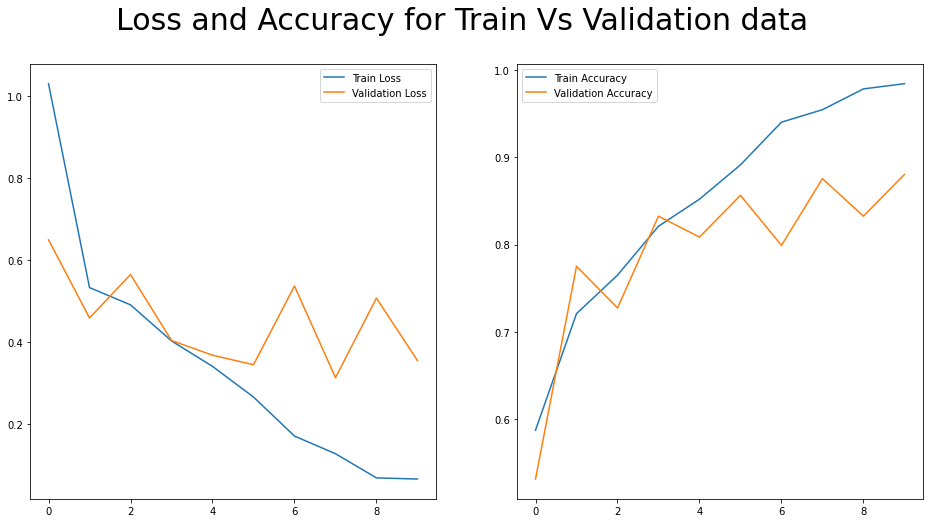

In [86]:
# Plotting loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8),)
fig.suptitle('Loss and Accuracy for Train Vs Validation data', fontsize =30)
figsize=(16,16),
ax1.plot(base.history['loss'], label = 'Train Loss'),
ax1.plot(base.history['val_loss'], label = 'Validation Loss'),
ax1.legend()
ax2.plot(base.history['accuracy'], label = 'Train Accuracy'),
ax2.plot(base.history['val_accuracy'], label = 'Validation Accuracy')
ax2.legend();
plt.savefig('/content/drive/MyDrive/Capstone/figures/no_augmentation_plot')

Model is overfit (training set performs better in terms of accuracy compared to validation set). 97% accuracy on the training set is great, but the validatiion set has a significantly lower accuracy of 88%, with a larger loss.

Nonetheless, this base CNN model performs much better than the null model with its accuracy of 50%.

Since dataset is small, can use data augmentation to artificially introduce diversity into the set by flipping images in different orientations.

---
## CNN Model with Data Augmentation

---

This section uses data augmentation to help train the model.

In [ ]:
# Instantiate data augmentation.
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

Text(0.5, 0.98, 'Bear Scat with Augmentation Applied')

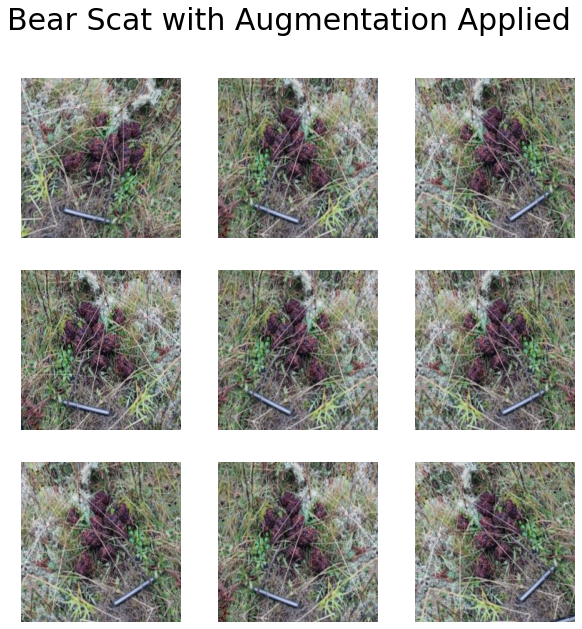

In [87]:
# Plot an image with data augmentation applied.
plt.figure(figsize=(10, 10))
for images, _ in train_df.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

plt.suptitle('Bear Scat with Augmentation Applied', fontsize = 30) 
#plt.savefig('/content/drive/MyDrive/Capstone/figures/image_augmentation')

In [ ]:
# Apply `data_augmentation` to the training images. 
train_df = train_df.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetch samples in GPU memory to help maximize GPU utilization. 
train_df = train_df.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

Code adapted from [source](https://keras.io/examples/vision/image_classification_from_scratch/).

In [88]:
# Rcereate base CNN model, this time using augmented data.
model_2 = Sequential()

model_2.add(layers.Input(shape = (256,256,3)))\



# The 1. below guarentees a float for the normalization.
model_2.add(layers.Rescaling(1./255))


# Add first convolution.
model_2.add(Conv2D(64, # Number of filters
                 (3,3), # Kernal size, generally 3 by 3
                 activation = 'relu'))

# Pass into the max pooling layer.
model_2.add(MaxPooling2D(pool_size = (2,2), # Default pool size
                       ))
# Add second Convolution
model_2.add(Conv2D(64, (3,3), activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2,2)))

# Flatten.
model_2.add(Flatten())

# Add Dropout layer.
model_2.add(Dropout(.5))

# Fully connected layers.
model_2.add(Dense(64, activation='relu'))
model_2.add(Dense(1, activation='sigmoid'))

#Compile model.
model_2.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'],
)

In [89]:
# Fitting augmented model with 5 epochs
augmented_base = model_2.fit(train_df, validation_data= val_ds, epochs = 10, workers = 8, callbacks = [es])

Epoch 1/10
27/27 [==============================] - 3s 33ms/step - loss: 1.2727 - accuracy: 0.5191 - val_loss: 0.6672 - val_accuracy: 0.5455
Epoch 2/10
27/27 [==============================] - 1s 28ms/step - loss: 0.5024 - accuracy: 0.7780 - val_loss: 0.4651 - val_accuracy: 0.7990
Epoch 3/10
27/27 [==============================] - 1s 27ms/step - loss: 0.4207 - accuracy: 0.8317 - val_loss: 0.3881 - val_accuracy: 0.8612
Epoch 4/10
27/27 [==============================] - 1s 28ms/step - loss: 0.2848 - accuracy: 0.8890 - val_loss: 0.3835 - val_accuracy: 0.8421
Epoch 5/10
27/27 [==============================] - 1s 27ms/step - loss: 0.1461 - accuracy: 0.9499 - val_loss: 0.4406 - val_accuracy: 0.8517
Epoch 6/10
27/27 [==============================] - 1s 27ms/step - loss: 0.0915 - accuracy: 0.9761 - val_loss: 0.3577 - val_accuracy: 0.8517
Epoch 7/10
27/27 [==============================] - 1s 27ms/step - loss: 0.0654 - accuracy: 0.9869 - val_loss: 0.3677 - val_accuracy: 0.8660
Epoch 8/10
27

In [90]:
# Scoring model
print(augmented_base.history['loss'][-1], augmented_base.history['val_loss'][-1])
print(augmented_base.history['accuracy'][-1], augmented_base.history['val_accuracy'][-1])

0.03924184665083885 0.6703997254371643
0.9928401112556458 0.7990430593490601


The model is less overfit due to the augmentation. 

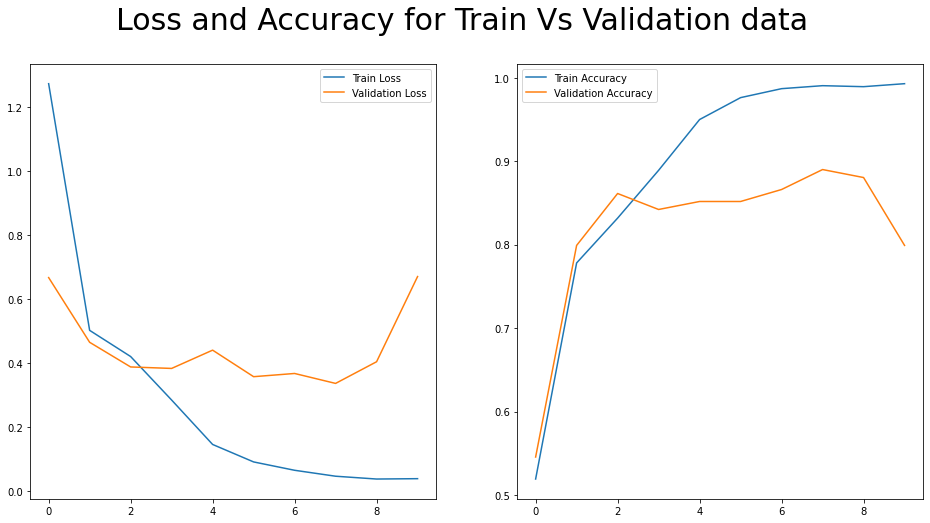

In [91]:
# Plotting loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8),)
fig.suptitle('Loss and Accuracy for Train Vs Validation data', fontsize =30)
figsize=(16,16),
ax1.plot(augmented_base.history['loss'], label = 'Train Loss'),
ax1.plot(augmented_base.history['val_loss'], label = 'Validation Loss'),
ax1.legend()
ax2.plot(augmented_base.history['accuracy'], label = 'Train Accuracy'),
ax2.plot(augmented_base.history['val_accuracy'], label = 'Validation Accuracy')
ax2.legend();
plt.savefig('/content/drive/MyDrive/Capstone/figures/with_image_augmentation')

---
# Testing CNN model 

This section uses a few test images to see how the model performs.

In [94]:
# Turn bear poo image into array to feed into model to predict.
test_img_bear = img_to_array(load_img('/content/drive/MyDrive/Capstone/test_bear/4.jpg'))
test_img_bear.shape

(194, 259, 3)

In [95]:
# Need to reshape image.
test_img_bear = smart_resize(test_img_bear, (256,256))
test_img_bear.shape

(256, 256, 3)

In [96]:
# Adding extra dimension for model to work.
test_img_bear = np.expand_dims(test_img_bear, axis = 0)
test_img_bear.shape

(1, 256, 256, 3)

In [97]:
# Predicting if image is bear scat.
model_2.predict(test_img_bear)

1/1 [==============================] - 0s 172ms/step


array([[0.99808073]], dtype=float32)

The model is over 99% sure the image contains bear scat.





In [104]:
# Turn not bear poo image into array to feed into model to predict.
test_img_not = img_to_array(load_img('/content/drive/MyDrive/Capstone/test_not_bear/1.jpg'))
test_img_not.shape

(181, 278, 3)

In [105]:
# Need to reshape image.
test_img_not = smart_resize(test_img_not, (256,256))
test_img_not.shape

(256, 256, 3)

In [106]:
# Adding extra dimension for model to work
test_image_not = np.expand_dims(test_img_not, axis = 0)
test_image_not.shape

(1, 256, 256, 3)

In [108]:
# Predicting if image is bear scat.
model_2.predict(test_image_not)

1/1 [==============================] - 0s 37ms/step


array([[0.15150367]], dtype=float32)

In [ ]:

Image('/content/drive/MyDrive/datasets/hotdog-nothotdog/hot_weiner.jpg')

Our model is 85% sure this is not bear scat.

In [109]:
#Save model as tensor flow type model, for future use in applications (ie. Streamlit).
model.save('/content/drive/MyDrive/Capstone/models/model2.h5')
model_2.save('/content/drive/MyDrive/Capstone/models/model2.h5')

---
### Next Steps

In the next section, we attempt a transfer learning model (a pre-trained model) to see if it performs better than our CNN model.

---